## Demo

Demo code for latent-space-inversion using a 2D multi-Gaussian field dataset and a linear forward model as the simulator.

For nonlinear forward model, simply replace "dataset.simulator" with the nonlinear simulation function. 

In [2]:
import random
import string
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.cm as cm
from matplotlib.colors import Normalize
%matplotlib inline

import dataloader
import util
import autoencoderdual

class_names = ['Meandering', 'Anastomosing-0', 
               'Anastomosing-135', 'Anastomosing-90', 'Anastomosing-45']
sc_index = class_names.index('Anastomosing-135')

#load data and filter by scenario
dataset = dataloader.DataLoader(simulator=np.load('G100.npy'), scenario = sc_index, verbose=True)
x_train, x_test, y_reg_train, y_reg_test = dataset.load_data()

Running simulation  0
Running simulation  1
Running simulation  2
Running simulation  3
Running simulation  4
Running simulation  5
Running simulation  6
Running simulation  7
Running simulation  8
Running simulation  9
Running simulation  10
Running simulation  11
Running simulation  12
Running simulation  13
Running simulation  14
Running simulation  15
Running simulation  16
Running simulation  17
Running simulation  18
Running simulation  19
Running simulation  20
Running simulation  21
Running simulation  22
Running simulation  23
Running simulation  24
Running simulation  25
Running simulation  26
Running simulation  27
Running simulation  28
Running simulation  29
Running simulation  30
Running simulation  31
Running simulation  32
Running simulation  33
Running simulation  34
Running simulation  35
Running simulation  36
Running simulation  37
Running simulation  38
Running simulation  39
Running simulation  40
Running simulation  41
Running simulation  42
Running simulation  4

Running simulation  346
Running simulation  347
Running simulation  348
Running simulation  349
Running simulation  350
Running simulation  351
Running simulation  352
Running simulation  353
Running simulation  354
Running simulation  355
Running simulation  356
Running simulation  357
Running simulation  358
Running simulation  359
Running simulation  360
Running simulation  361
Running simulation  362
Running simulation  363
Running simulation  364
Running simulation  365
Running simulation  366
Running simulation  367
Running simulation  368
Running simulation  369
Running simulation  370
Running simulation  371
Running simulation  372
Running simulation  373
Running simulation  374
Running simulation  375
Running simulation  376
Running simulation  377
Running simulation  378
Running simulation  379
Running simulation  380
Running simulation  381
Running simulation  382
Running simulation  383
Running simulation  384
Running simulation  385
Running simulation  386
Running simulati

## Train LSI model 

In practice, we have only:

1. Model realizations (from multiple scenarios) as "x_train",
2. Pre-defined scenario label as "y_train", and
3. A forward simulator as "dataset.simulator",

and we run forward simulations to obtain production responses "y_reg_train".

In [3]:
#load lsi architecture
LSI = autoencoderdual.Autoencoder(x_train, y_reg_train)
LSI.train_autoencoder_dual(epoch=600, load=True)

#autoencoderdual.inspect_LSI(LSI, x_test, y_reg_test)
#autoencoderdual.inspect_LSI_z(LSI, x_test, y_reg_test)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 500)          1024500     input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 500)          0           dense_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 300)          150300      leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
leaky_re_l

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
enc (Conv2D)                 (None, 100, 100, 4)       40        
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 100, 100, 4)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 4)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 8)         520       
_________________________________________________________________
batch_normalization_3 (Batch (None, 50, 50, 8)         32        
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 50, 50, 8)         0         
__________

In [4]:
#get variables
D_test_hat = LSI.d2d.predict(y_reg_test)
M_test_hat = LSI.m2m.predict(x_test)
M_test_hat_reg = (LSI.d2m.predict(y_reg_test))[1]

#take cut off (0 and 1, cutoff for discrettization)
M_test_hat_reg = np.where(M_test_hat_reg<0.2, 0, 1)

#get data latent variables
zd_test = LSI.d2zd.predict(y_reg_test)

#get model latent variables
zm_test = LSI.m2zm.predict(x_test)

#get data to model latent variables (inversion)
zm_test_reg = LSI.zd2zm.predict(zd_test)

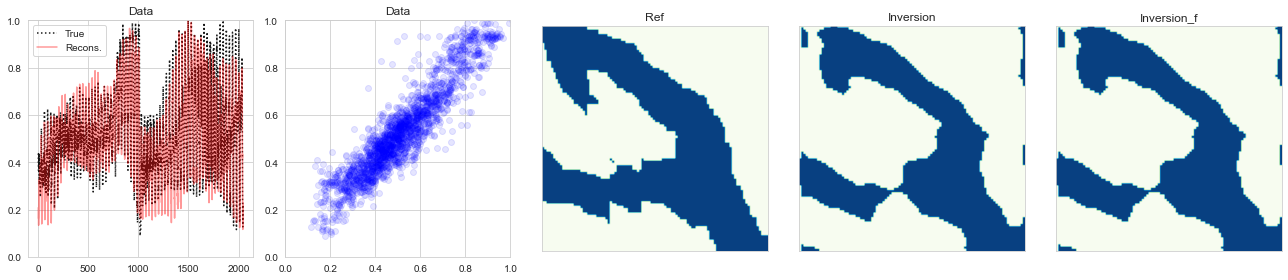

In [5]:
#reference case (in original dimension)

case = 13  
f = plt.figure(figsize=(18,4))
#data and data reconstruction
ax = f.add_subplot(1, 5, 1)
plt.plot(y_reg_test[case, :], ls=':', c='k', label='True', alpha=0.9)
plt.plot(D_test_hat[case, :], c='r', label='Recons.', alpha=0.4)
plt.ylim([0, 1])
plt.title('Data')
plt.legend()

#data and data reconstruction (scatter)
ax = f.add_subplot(1, 5, 2)
plt.scatter(D_test_hat[case, :].flatten(), y_reg_test[case, :].flatten(), color='blue', alpha=0.1)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('Data')
    
#model (i.e. reference case)
ax = f.add_subplot(1, 5, 3)
plt.imshow(x_test[case, :, :, 0], cmap=plt.cm.GnBu, vmin=0, vmax=1)
plt.title('Ref')
plt.grid(False), plt.xticks([]), plt.yticks([])

#predicted model (i.e. inversion)
ax = f.add_subplot(1, 5, 4)
plt.imshow(M_test_hat_reg[case, :, :, 0], cmap=plt.cm.GnBu, vmin=0, vmax=1)
plt.title('Inversion')
plt.grid(False), plt.xticks([]), plt.yticks([])

#predicted model (i.e. inversion) colormap limit removed to show diffr
ax = f.add_subplot(1, 5, 5)
plt.imshow(M_test_hat_reg[case, :, :, 0], cmap=plt.cm.GnBu)
plt.title('Inversion_f')
plt.grid(False), plt.xticks([]), plt.yticks([])

plt.tight_layout()
f.savefig('readme/test_sigs_ref_recons_demo.png', dpi=300)

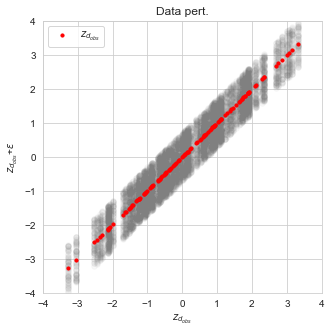

In [6]:
#workflow demo, with a reference case (index #3 in test dataset)
zd_obs = zd_test[case, :]

#sample the latent space around the observed data
num_samples = 64
zd_obs_pert = np.zeros([num_samples, zd_obs.shape[0]])
zd_obs_pert[:,:] = zd_obs

#perturb ~20%
pert = np.random.uniform(0, 1.4, [num_samples, zd_obs.shape[0]]) - 0.7
zd_obs_pert = zd_obs_pert + pert

#plot scatter
f = plt.figure(figsize=(5, 5))
plt.scatter(zd_obs.flatten(), zd_obs.flatten(), s=10, color='red', alpha=1, label="$z_{d_{obs}}$", zorder=20)
for i in range(num_samples):
    plt.scatter(zd_obs.flatten(), zd_obs_pert[i,:].flatten(), s=30, color='gray', alpha=0.05)
plt.xlim([-4, 4])
plt.ylim([-4, 4])
plt.xlabel("$z_{d_{obs}}$")
plt.ylabel("$z_{d_{obs}}$"+"+$\epsilon$")
plt.legend()
plt.title('Data pert.')
f.savefig('readme/test_zds_scatter_demo.png')

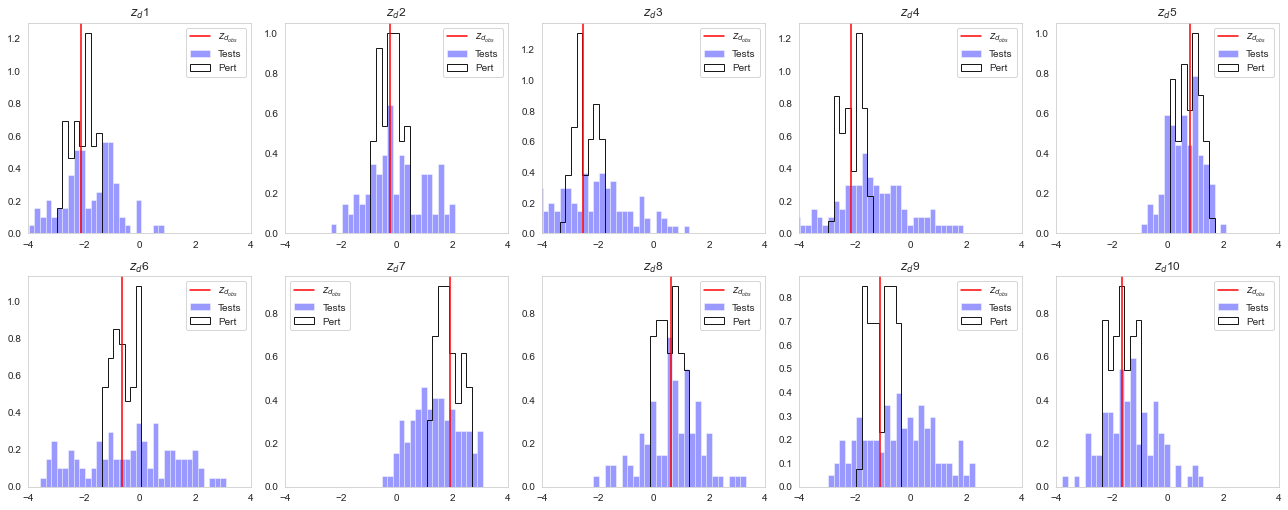

In [7]:
#latent spaces for the data

zd_obs = zd_test[case, :]

binmax = np.max(zd_obs)
binmin = np.min(zd_obs)
bb2 = np.linspace(binmin, binmax, 40)

f = plt.figure(figsize=(18, 14))
for i in range(10):
    plt.subplot(4, 5, i+1)
    plt.hist(zd_test[:, i].flatten(), color='blue', alpha=0.4, bins=bb2, density=True, label="Tests")
    plt.hist(zd_obs_pert[:, i].flatten(), color='blue', alpha=0.9, edgecolor='black', histtype='step', bins=bb2, density=True, label="Pert")
    plt.axvline(x=zd_obs[i], c='r', label="$z_{d_{obs}}$")
    plt.grid(False)
    plt.xlim(-4, 4), 
    plt.title('$z_{d}$'+str(i+1))
    plt.legend()
f.tight_layout()
f.savefig('readme/test_zds_demo.png', dpi=300)

In [8]:
#get the corresponding model latent variables
zm_ref_pert = LSI.zd2zm.predict(zd_obs_pert)

#get the inversion solutions for the perturbed set
M_test_hat_reg_pert = LSI.zm2m.predict(zm_ref_pert)

#take cut off (0 and 1, cutoff at 0.5 for discrettization)
M_test_hat_reg_pert = np.where(M_test_hat_reg_pert<0.2, 0, 1)

#run forward simulation on the perturbed images
D_test_hat_reg_pert = dataset.simulator(M_test_hat_reg_pert)
    
#normalize using the same normalization factor for the training dataset
D_test_hat_reg_pert = dataset.normalize_data_(D_test_hat_reg_pert)

Running simulation  0
Running simulation  1
Running simulation  2
Running simulation  3
Running simulation  4
Running simulation  5
Running simulation  6
Running simulation  7
Running simulation  8
Running simulation  9
Running simulation  10
Running simulation  11
Running simulation  12
Running simulation  13
Running simulation  14
Running simulation  15
Running simulation  16
Running simulation  17
Running simulation  18
Running simulation  19
Running simulation  20
Running simulation  21
Running simulation  22
Running simulation  23
Running simulation  24
Running simulation  25
Running simulation  26
Running simulation  27
Running simulation  28
Running simulation  29
Running simulation  30
Running simulation  31
Running simulation  32
Running simulation  33
Running simulation  34
Running simulation  35
Running simulation  36
Running simulation  37
Running simulation  38
Running simulation  39
Running simulation  40
Running simulation  41
Running simulation  42
Running simulation  4

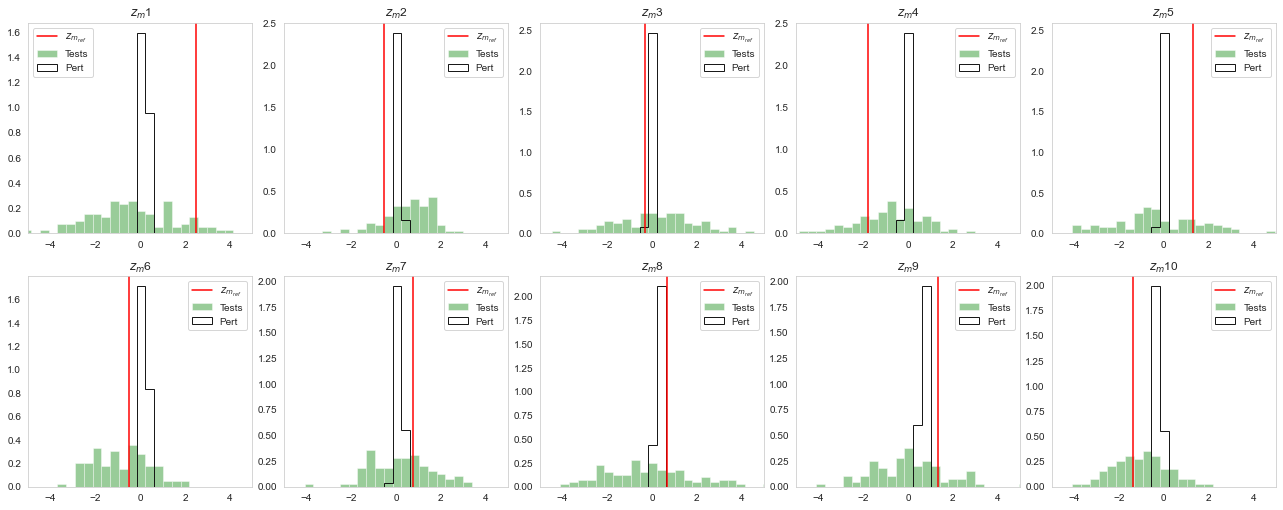

In [9]:
#latent spaces for the model

zm_ref = zm_test[case, :]

binmax = np.max(zm_ref)
binmin = np.min(zm_ref)
bb2 = np.linspace(binmin, binmax, 40)

f = plt.figure(figsize=(18, 14))
for i in range(10):
    plt.subplot(4, 5, i+1)
    plt.hist(zm_test[:, i].flatten(), color='green', alpha=0.4, bins=bb2, density=True, label="Tests")
    plt.hist(zm_ref_pert[:, i].flatten(), color='green', alpha=0.9, edgecolor='black', histtype='step', bins=bb2, density=True, label="Pert")
    plt.axvline(x=zm_ref[i], c='r', label="$z_{m_{ref}}$")
    plt.grid(False)
    plt.xlim(-5, 5), 
    plt.title('$z_{m}$'+str(i+1))
    plt.legend()
f.tight_layout()
f.savefig('readme/test_zms_demo.png', dpi=300)

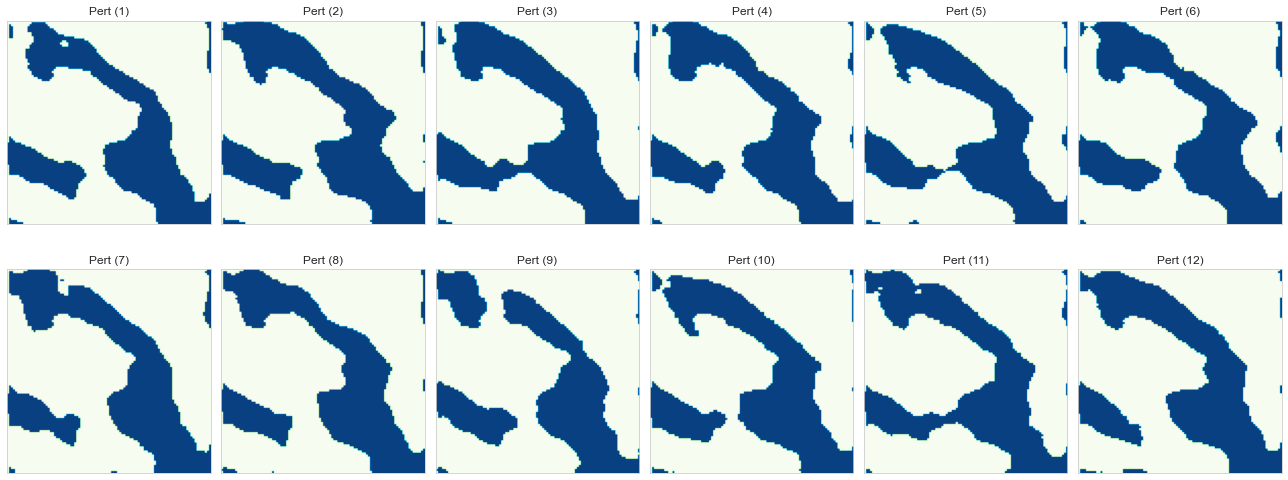

In [10]:
#view perturbed images (rescaled)

f = plt.figure(figsize=(18, 14))
for i in range(12):
    plt.subplot(4, 6, i+1)
    plt.imshow(M_test_hat_reg_pert[i, :, :, 0], cmap=plt.cm.GnBu)
    plt.title('Pert ('+str(i+1)+')')
    plt.grid(False), plt.xticks([]), plt.yticks([])
plt.tight_layout()
f.savefig('readme/test_m_pert_demo.png', dpi=300)

D:\13108\anaconda3\envs\Py36\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
D:\13108\anaconda3\envs\Py36\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


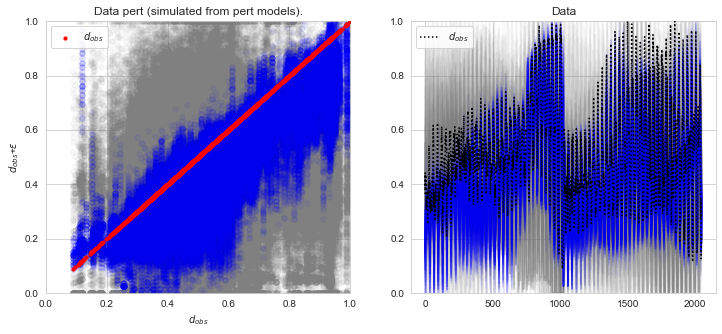

In [11]:
#view perturbed data

f = plt.figure(figsize=(12, 5))
ax = f.add_subplot(1, 2, 1)
plt.scatter(y_reg_test[case,:].flatten(), y_reg_test[case,:].flatten(), s=10, color='red', alpha=1, label="$d_{obs}$", zorder=20)
for i in range(100):
    plt.scatter(y_reg_test[case,:].flatten(), y_reg_test[i,:].flatten(), s=30, color='gray', alpha=0.05)
for i in range(num_samples):
    plt.scatter(y_reg_test[case,:].flatten(), D_test_hat_reg_pert[i,:].flatten(), s=30, color='b', alpha=0.05)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("$d_{obs}$")
plt.ylabel("$d_{obs}$"+"+$\epsilon$")
plt.legend()
plt.title('Data pert (simulated from pert models).')

ax = f.add_subplot(1, 2, 2)
timesteps = np.linspace(0, 2047, 2048)
plt.plot(timesteps, y_reg_test[case,:], ls=':', c='k', alpha=1, label="$d_{obs}$", zorder=20)
for i in range(100):
    plt.plot(timesteps, y_reg_test[i,:], color='gray', alpha=0.05)
for i in range(num_samples):
    plt.plot(timesteps, D_test_hat_reg_pert[i,:], color='b', alpha=0.05)
plt.ylim([0, 1])
plt.title('Data')
plt.legend()
f.savefig('readme/test_d_pert_demo.png', dpi=300)

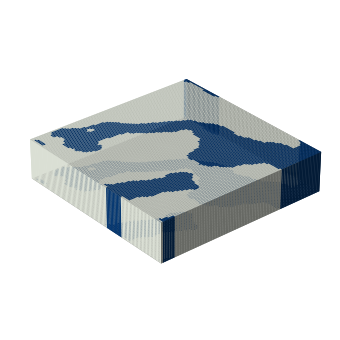

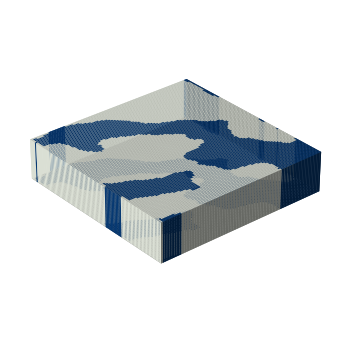

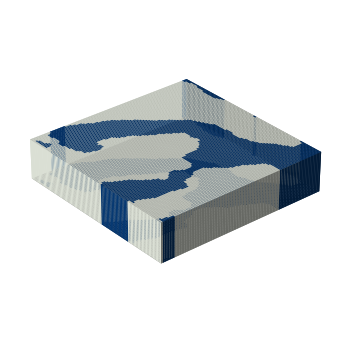

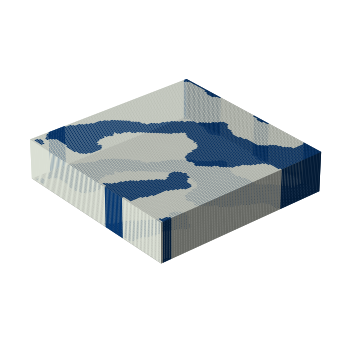

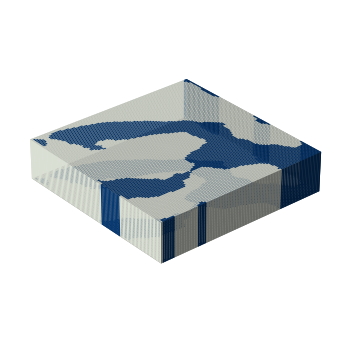

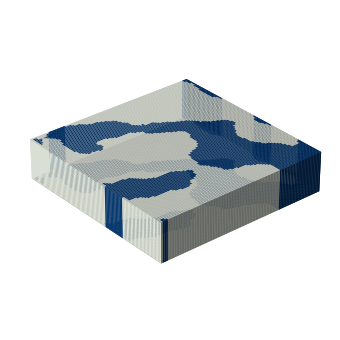

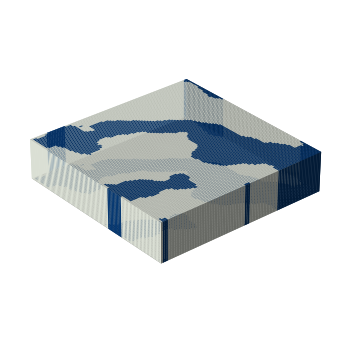

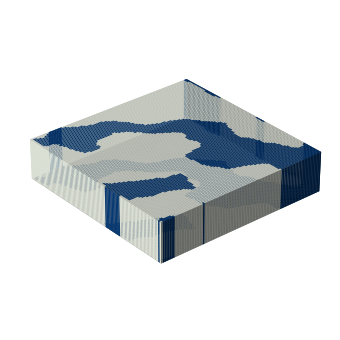

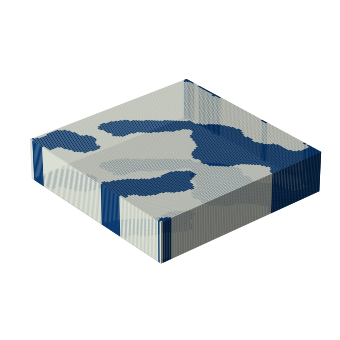

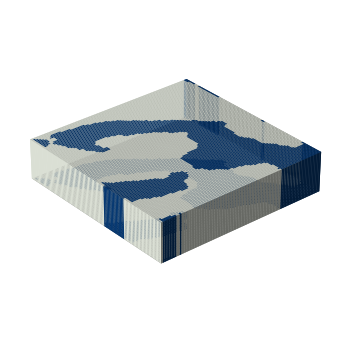

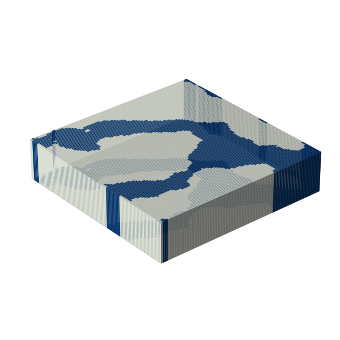

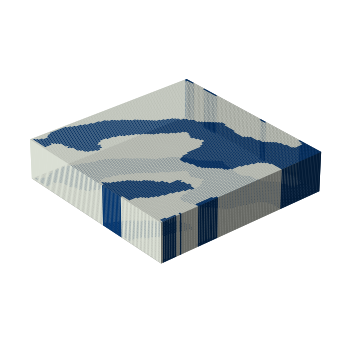

In [13]:
#for display 

for i in range(12):
    util.plot_cube(np.squeeze(M_test_hat_reg_pert[i, :, :, 0]))